# Whisper Transcribe
OpenAI Whisper test and evaluation for German language audio files.

DUT 1:
* Nvidia RTX 3070 (8GB)
* 64GB RAM

DUT 2:
* Apple M1 Max (10-Core CPU, 32-Core GPU, 16-Core Neural Engine)
* 32GB RAM

## Execution
For the different available models, perform transcription and match the output to the manual transcript.

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
import whisper
from datetime import datetime
from difflib import SequenceMatcher

In [7]:
# init SequenceMatcher
similar = lambda a, b: SequenceMatcher(None, a, b).ratio()

audio_file = os.path.join(os.getcwd(), '20221007_stochastik_zufall.m4a')  # path to file
audio_length = 22  # seconds
manual_transcript = """Zufall ist, in unserem Kontext, nicht ein im Hintergrund unseres Daseins wirkendes Prinzip, das unser Leben zu beeinträchtigen in der Lage ist, sondern das Wort dient zur Charakterisierung einer Situation, in der wir auf Grund fehlender Informationen den Ausgang eines Experiments nicht vorhersehen können."""
language_whisper = "German"
device = "cuda" if torch.cuda.is_available() else "cpu"

results_df = pd.DataFrame({
    "Model": ["tiny", "base", "small", "medium", "large"],
    "Language": "German",
    "Manual Transcript": manual_transcript,
    "Audio Length": audio_length,
    "Whisper Transcript": str(),
    "Transcription Duration": np.nan,   # duration in s
    "t-t Factor": np.nan,               # duration / audio length
    "Match": np.nan                     # match in %
})

In [8]:
for idx, w_model in enumerate(results_df.Model):
    # load model
    model = whisper.load_model(w_model, device=device)  # select model: tiny, base, small, medium, large
    
    timestamp_start = datetime.now()
    result = model.transcribe(audio_file, language=language_whisper)
    timestamp_end = datetime.now()

    results_df.iloc[idx, 4] = result['text']
    results_df.iloc[idx, 5] = (timestamp_end - timestamp_start).seconds
    results_df.iloc[idx, 6] = round(results_df.iloc[idx, 5]/audio_length, 2)
    results_df.iloc[idx, 7] = round(similar(manual_transcript, result['text']) * 100, 2)
    
print(results_df[["Model", "Transcription Duration", "t-t Factor", "Match"]])

/Users/jannikschmied/opt/anaconda3/envs/data-analysis/lib/python3.10/site-packages/whisper/transcribe.py:78: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/Users/jannikschmied/opt/anaconda3/envs/data-analysis/lib/python3.10/site-packages/whisper/transcribe.py:78: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/Users/jannikschmied/opt/anaconda3/envs/data-analysis/lib/python3.10/site-packages/whisper/transcribe.py:78: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/Users/jannikschmied/opt/anaconda3/envs/data-analysis/lib/python3.10/site-packages/whisper/transcribe.py:78: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/Users/jannikschmied/opt/anaconda3/envs/data

    Model  Transcription Duration  t-t Factor  Match
0    tiny                     3.0        0.14  80.46
1    base                     5.0        0.23  96.20
2   small                    12.0        0.55  98.52
3  medium                    33.0        1.50  99.18
4   large                    56.0        2.55  99.18


## Evaluation

Evaluation and visualization of the outcome.
All values are to be understood as averages of 100 trials.

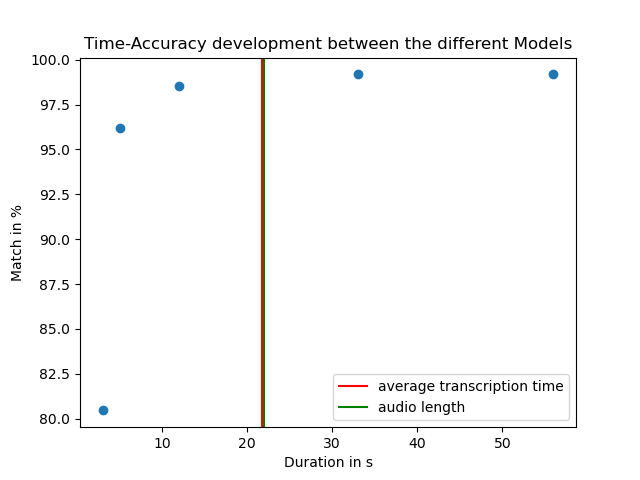

In [9]:
transcription_time_avg = np.mean(results_df["Transcription Duration"])

%matplotlib widget
plt.scatter(results_df["Transcription Duration"], results_df["Match"])
plt.axvline(transcription_time_avg, color="red", label="average transcription time")
plt.axvline(audio_length, color="green", label="audio length")
plt.legend(loc="lower right")
plt.xlabel("Duration in s")
plt.ylabel("Match in %")
plt.title("Time-Accuracy development between the different Models")
plt.show()